In [1]:
import numpy as np
import tensorflow as tf
import string
import pandas as pd
import gensim
from datasets import Dataset
import spacy
import core.model_utils as model_utils
import core.constants as constants
import matplotlib.pyplot as plt
import os

In [2]:
# https://github.com/sdadas/polish-nlp-resources#word2vec (needs to be downloaded manually)
word2vec_kv = gensim.models.KeyedVectors.load("./word2vec/word2vec_100_3_polish.bin")

In [3]:
def tokens_to_vector(tokens):
    vector_size = word2vec_kv.vector_size
    wv_res = np.zeros(vector_size)
    ctr = 1
    for w in tokens:
        if w in word2vec_kv:
            ctr += 1
            wv_res += word2vec_kv[w]
    wv_res = wv_res / ctr
    return wv_res

In [4]:
# Needs to be used to download spacy model for Polish
# !python -m spacy download pl_core_news_sm

In [5]:
# spacy_model = spacy.load("pl_core_news_sm")
#
# # Stop words
# stop_words = spacy_model.Defaults.stop_words.copy()
# stop_words.remove("nie")
#
# # Punctuation
# punctuations = string.punctuation
#
#
# # Tokenizer
# def spacy_tokenizer(sentence):
#     doc = spacy_model(sentence)
#
#     # Lemmatizing each token and converting each token into lowercase
#     my_tokens = [ word.lemma_.lower().strip() for word in doc ]
#
#     # Removing stop words and punctuation
#     my_tokens = [ word for word in my_tokens if word not in stop_words and word not in punctuations ]
#     return my_tokens
#
#
# df = pd.read_json('./../data/polish_translated/emotions/equalized_emotions_dataset_pl.json')
# df = df.drop(columns=['text'])
# df['tokens'] = df['text_pl'].apply(spacy_tokenizer)
# df['joined_tokens'] = df['tokens'].apply(lambda tokens: ' '.join(tokens))
# df.to_json('./../data/polish_translated/emotions/equalized_emotions_dataset_pl_with_tokens.json')

In [6]:
tokenized_sentences_df = pd.read_json(
    './../data/polish_translated/emotions/equalized_emotions_dataset_pl_with_tokens.json')
tokenized_sentences_df

,emotions,text_pl,tokens,joined_tokens
0,anger,Czuję się całkowicie chciwy,"[czuję, całkowicie, chciwy]",czuję całkowicie chciwy
1,fear,Czuję się tak przytłoczony emocjami,"[czuję, przytłocić, emocja]",czuję przytłocić emocja
2,surprise,Nie czułem efektu siły g Jestem oszołomiony Po...,"[nie, czuć, być, efekt, siła, g, oszołomiona, ...",nie czuć być efekt siła g oszołomiona poszedłe...
3,anger,ive just got to tell you all that I feel Racze...,"[ive, just, got, tell, you, all, that, feel, r...",ive just got tell you all that feel raczej nie...
4,anger,"Powiedziałem ci, że przepraszam, że czujesz si...","[powiedzieć, być, przepraszać, czuć, sfrustrow...",powiedzieć być przepraszać czuć sfrustrowany z...
...,...,...,...,...
39995,joy,"czuję się ostatnio dość hojny, ponieważ pracuj...","[czuć, ostatnio, hojny, pracować, znacznie, zw...",czuć ostatnio hojny pracować znacznie zwykle z...
39996,love,"Czuję, że niektóre postacie nie zasługują na w...","[czuję, niektóry, postać, nie, zasługiwać, wsp...",czuję niektóry postać nie zasługiwać wsparcie ...
39997,fear,"Czuję strach w moich kościach, którego nie moż...","[czuję, strach, kość, nie, móc, wytrząsnąć, wy...",czuję strach kość nie móc wytrząsnąć wymuszć r...
39998,joy,Czułem się bardziej kreatywny i mniej jak czys...,"[czuć, być, kreatywny, czysty, redaktor]",czuć być kreatywny czysty redaktor


In [7]:
ordered_class_labels = {
    "joy": 0,
    "love": 1,
    "surprise": 2,
    "sadness": 3,
    "anger": 4,
    "fear": 5,
}

tokenized_sentences_df = tokenized_sentences_df.replace({"emotions": ordered_class_labels})

In [8]:
emotions = [0, 1]
result_df = tokenized_sentences_df[tokenized_sentences_df['emotions'].isin(emotions)]

In [9]:
len(result_df)

13334

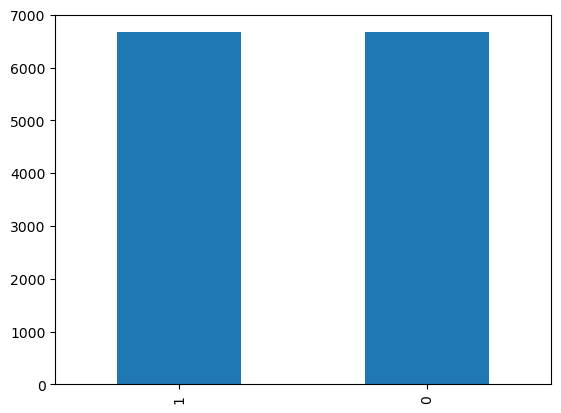

In [9]:
data = result_df["emotions"]
data.value_counts().plot.bar()
plt.show()

In [10]:
full_dataset = Dataset.from_pandas(result_df).remove_columns("__index_level_0__")
full_dataset

Dataset({
    features: ['emotions', 'text_pl', 'tokens', 'joined_tokens'],
    num_rows: 13334
})

In [11]:
# Train set: 80%, Validation set: 10%, Test set: 10%
train_dataset, val_dataset, test_dataset = model_utils.split_train_val_test(
    full_dataset,
    train_size=0.8,
    test_size_of_val_test_batch=0.5,
    shuffle=True,
    seed=42)

In [12]:
def tokenize_for_word2vec(sample):
    sample['embeddings'] = [tokens_to_vector(tokens) for tokens in sample['tokens']]
    return sample


train_dataset = train_dataset.map(tokenize_for_word2vec, batched=True)
val_dataset = val_dataset.map(tokenize_for_word2vec, batched=True)
test_dataset = test_dataset.map(tokenize_for_word2vec, batched=True)

Map:   0%|          | 0/10667 [00:00<?, ? examples/s]

Map:   0%|          | 0/1333 [00:00<?, ? examples/s]

Map:   0%|          | 0/1334 [00:00<?, ? examples/s]

In [13]:
columns = ["embeddings"]
label_cols = ["emotions"]
batch_size = 16

tf_train_dataset = model_utils.convert_to_tf_dataset(train_dataset, columns, label_cols, None, batch_size)
tf_val_dataset = model_utils.convert_to_tf_dataset(val_dataset, columns, label_cols, None, batch_size)
tf_test_dataset = model_utils.convert_to_tf_dataset(test_dataset, columns, label_cols, None, batch_size)

C:\Users\Karol\anaconda3\envs\ml-tf2gpu\lib\site-packages\datasets\arrow_dataset.py:388: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [14]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(2, activation='sigmoid'))

In [15]:
model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])

In [16]:
# Model parameters
training_number = 2
model_name = 'emotions_pl_word2vec_binary_0_1_external'
training_name = f"training_{training_number}"
figures_dir = f"./../documentation/models/{model_name}/figures"
checkpoint_filename_template = "cp-{epoch:04d}.ckpt"
checkpoints_dir = os.path.join(constants.TRAINING_CHECKPOINTS_PATH, model_name, training_name)
checkpoint_path = os.path.join(checkpoints_dir, checkpoint_filename_template)

In [17]:
# Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True)
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=3)
callbacks = [checkpoint_cb, early_stop_cb]

In [18]:
history = model.fit(tf_train_dataset, validation_data=tf_val_dataset, epochs=20,
                    callbacks=[checkpoint_cb, early_stop_cb])

Epoch 1/20
667/667 [==============================] - 6s 3ms/step - loss: 0.6122 - accuracy: 0.6553 - val_loss: 0.5792 - val_accuracy: 0.6834

Epoch 00001: saving model to ./../training_checkpoints\emotions_pl_word2vec_binary_0_1_external\training_2\cp-0001.ckpt
Epoch 2/20
667/667 [==============================] - 1s 2ms/step - loss: 0.5593 - accuracy: 0.7022 - val_loss: 0.5553 - val_accuracy: 0.7104

Epoch 00002: saving model to ./../training_checkpoints\emotions_pl_word2vec_binary_0_1_external\training_2\cp-0002.ckpt
Epoch 3/20
667/667 [==============================] - 1s 2ms/step - loss: 0.5331 - accuracy: 0.7225 - val_loss: 0.5413 - val_accuracy: 0.7187

Epoch 00003: saving model to ./../training_checkpoints\emotions_pl_word2vec_binary_0_1_external\training_2\cp-0003.ckpt
Epoch 4/20
667/667 [==============================] - 1s 2ms/step - loss: 0.5058 - accuracy: 0.7439 - val_loss: 0.5367 - val_accuracy: 0.7202

Epoch 00004: saving model to ./../training_checkpoints\emotions_pl_w

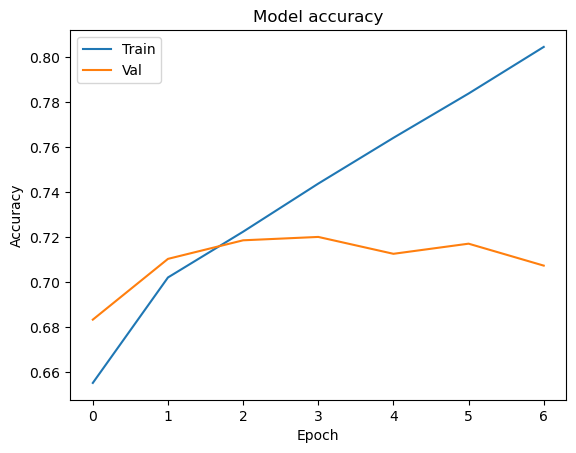

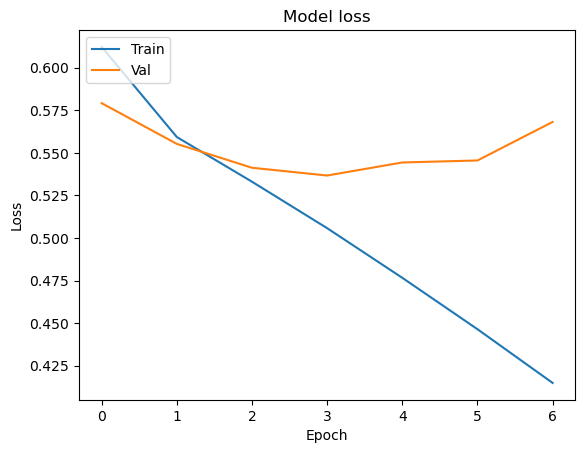

In [19]:
model_utils.plot_and_save_fig_from_history(history,
                                           attributes=['accuracy', 'val_accuracy'],
                                           title='Model accuracy',
                                           y_label='Accuracy',
                                           x_label='Epoch',
                                           legend_descriptors=['Train', 'Val'],
                                           figure_dir_path=figures_dir,
                                           figure_filename=f"{training_name}_accuracy.png")

model_utils.plot_and_save_fig_from_history(history,
                                           attributes=['loss', 'val_loss'],
                                           title='Model loss',
                                           y_label='Loss',
                                           x_label='Epoch',
                                           legend_descriptors=['Train', 'Val'],
                                           figure_dir_path=figures_dir,
                                           figure_filename=f"{training_name}_loss.png")

In [20]:
best_model = model_utils.get_best_model_from_checkpoints(model, history,
                                                         checkpoints_dir=checkpoints_dir,
                                                         checkpoint_filename_template=checkpoint_filename_template)

In [21]:
model_utils.save_model(best_model, model_name=model_name, training_number=training_number, saved_models_dir=constants.SAVED_MODEL_LOCATION, default_model_version=constants.DEFAULT_MODEL_VERSION)

INFO:tensorflow:Assets written to: ./../trained_models\emotions_pl_word2vec_binary_0_1_external_2\1\assets


In [22]:
# Evaluation
best_model.evaluate(tf_test_dataset, batch_size=batch_size)

84/84 [==============================] - 0s 2ms/step - loss: 0.5681 - accuracy: 0.7226


[0.5680667757987976, 0.7226386666297913]

In [23]:
class_preds = model_utils.get_class_preds(best_model, tf_test_dataset, model_returns_logits=False)

In [24]:
precision, recall, f1 = model_utils.get_classification_evaluation_metrics(
    class_actual=test_dataset['emotions'],
    class_preds=class_preds,
)

print(f"Precision score: ", precision)
print(f"Recall score: ", recall)
print(f"F1 score: ", f1)

Precision score:  0.7151424287856072
Recall score:  0.726027397260274
F1 score:  0.7205438066465256


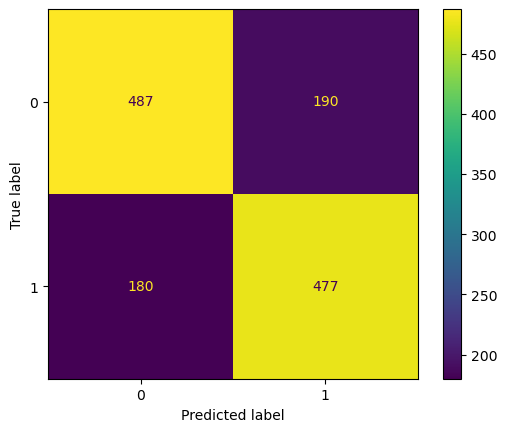

In [25]:
model_utils.plot_and_save_conf_matrix(class_actual=test_dataset['emotions'],
                                      class_preds=class_preds,
                                      figure_dir_path=figures_dir,
                                      figure_filename=f"{training_name}_confmatrix.png")

In [26]:
model_utils.print_incorrectly_predicted_texts(texts=test_dataset['text_pl'],
                                              class_actual=test_dataset['emotions'],
                                              class_preds=class_preds)


            BAD PREDICTION:
            - INDEX: 2
            - TEXT: Nie czuję się wierny w czasie i potykam się
            - PREDICTED VALUE: 0
            - CORRECT VALUE: 1
            

            BAD PREDICTION:
            - INDEX: 4
            - TEXT: Czuję, że dzieci zaakceptowały mnie jako przyjaciela w swoich kręgach.
            - PREDICTED VALUE: 1
            - CORRECT VALUE: 0
            

            BAD PREDICTION:
            - INDEX: 11
            - TEXT: Czuję, że to naprawdę wspaniały sposób na świętowanie bycia mamą i bycia rodziną. Moje córki i córki Keitha śmieją się, widać włosy.
            - PREDICTED VALUE: 0
            - CORRECT VALUE: 1
            

            BAD PREDICTION:
            - INDEX: 15
            - TEXT: Nie czułem się rozbawiony zachowaniem moich szefów, więc łagodzi mnie wiedza, że nie jestem sadystą
            - PREDICTED VALUE: 1
            - CORRECT VALUE: 0
            

            BAD PREDICTION:
            - INDEX: 20
 

In [27]:
test_df = pd.DataFrame(
    list(zip(test_dataset['text_pl'], test_dataset['emotions'], class_preds)),
    columns=['text_pl', 'emotions', 'prediction'])
test_df

,text_pl,emotions,prediction
0,"Czuję, że w końcu zaakceptowałam swoje miejsce...",1,1
1,"Czuję się podwójnie błogosławiony tą łaską, po...",1,1
2,Nie czuję się wierny w czasie i potykam się,1,0
3,"Czuję, że przynajmniej raz dziennie Bóg musi m...",1,1
4,"Czuję, że dzieci zaakceptowały mnie jako przyj...",0,1
...,...,...,...
1329,Jestem wdzięczna za moich wspaniałych rodziców...,0,0
1330,"Nienawidzę tego, kto potrzebował jej oddechu, ...",1,1
1331,Czuję się dobrze z indukcją i następnym jestem...,0,0
1332,"Czuję, że nawet z ilością czasu poświęconego n...",1,0


In [28]:
def map_token_counts(row):
    return len(row['text_pl'].split())

def map_count_belonging(row, divider):
    int_division_result = int(row['token_count'] / divider) + 1
    lower_boundary = divider * int_division_result - divider
    upper_boundary = divider * int_division_result - 1
    return f"{lower_boundary}-{upper_boundary}"

def map_correctly_predicted(row):
    return int(row['emotions'] == row['prediction'])


test_df['token_count'] = test_df.apply(lambda row: map_token_counts(row), axis=1)
test_df['count_belonging'] = test_df.apply(lambda row: map_count_belonging(row, divider=6), axis=1)
test_df['correctly_predicted'] = test_df.apply(lambda row: map_correctly_predicted(row), axis=1)
test_df

,text_pl,emotions,prediction,token_count,count_belonging,correctly_predicted
0,"Czuję, że w końcu zaakceptowałam swoje miejsce...",1,1,29,24-29,1
1,"Czuję się podwójnie błogosławiony tą łaską, po...",1,1,17,12-17,1
2,Nie czuję się wierny w czasie i potykam się,1,0,9,6-11,0
3,"Czuję, że przynajmniej raz dziennie Bóg musi m...",1,1,15,12-17,1
4,"Czuję, że dzieci zaakceptowały mnie jako przyj...",0,1,10,6-11,0
...,...,...,...,...,...,...
1329,Jestem wdzięczna za moich wspaniałych rodziców...,0,0,17,12-17,1
1330,"Nienawidzę tego, kto potrzebował jej oddechu, ...",1,1,29,24-29,1
1331,Czuję się dobrze z indukcją i następnym jestem...,0,0,20,18-23,1
1332,"Czuję, że nawet z ilością czasu poświęconego n...",1,0,19,18-23,0


In [29]:
test_df = test_df.drop(test_df[test_df.token_count > 29].index)

In [30]:
test_df = test_df.sort_values(by=['token_count']).reset_index(drop=True)

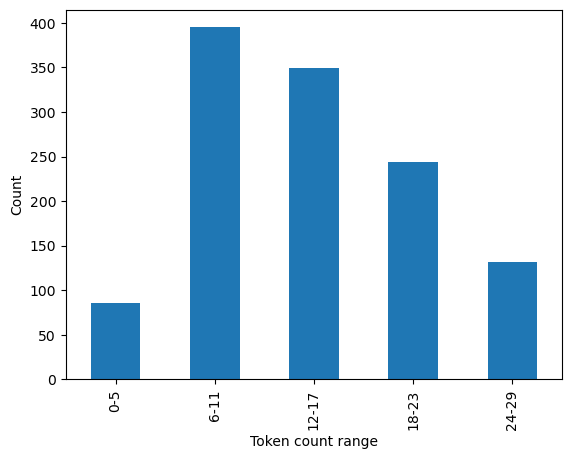

In [31]:
data = test_df['count_belonging']
data.value_counts(sort=False).plot.bar()
plt.xlabel('Token count range')
plt.ylabel('Count')
plt.savefig(os.path.join(figures_dir, f'{training_name}_counts_per_range.png'))
plt.show()

In [32]:
range_to_valid_predictions_count_dict = {'0-5': 0, '6-11': 0, '12-17': 0, '18-23': 0, '24-29': 0}
range_to_element_count_dict = {'0-5': 0, '6-11': 0, '12-17': 0, '18-23': 0, '24-29': 0}
range_to_pred_accuracy_dict = {'0-5': 0., '6-11': 0., '12-17': 0., '18-23': 0., '24-29': 0.}

In [33]:
for _, row in test_df.iterrows():
    count_belonging = row['count_belonging']

    range_to_element_count_dict[count_belonging] = range_to_element_count_dict[count_belonging] + 1

    if row['correctly_predicted']:
        range_to_valid_predictions_count_dict[count_belonging] = range_to_valid_predictions_count_dict[count_belonging] + 1

for key in range_to_pred_accuracy_dict.keys():
    range_to_pred_accuracy_dict[key] = range_to_valid_predictions_count_dict[key] / range_to_element_count_dict[key]

print("Correct predictions count: ", range_to_valid_predictions_count_dict)
print("Element count: ", range_to_element_count_dict)
print("Accuracies: ", range_to_pred_accuracy_dict)

Correct predictions count:  {'0-5': 74, '6-11': 293, '12-17': 252, '18-23': 170, '24-29': 89}
Element count:  {'0-5': 86, '6-11': 395, '12-17': 349, '18-23': 244, '24-29': 132}
Accuracies:  {'0-5': 0.8604651162790697, '6-11': 0.7417721518987341, '12-17': 0.7220630372492837, '18-23': 0.6967213114754098, '24-29': 0.6742424242424242}


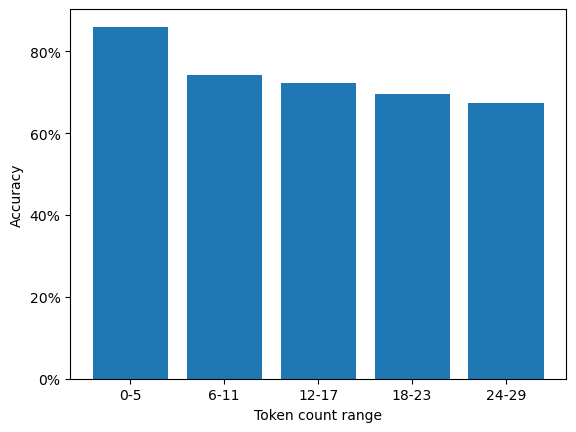

In [34]:
import matplotlib.ticker as mtick

plt.bar(['0-5', '6-11', '12-17', '18-23', '24-29'], [val for val in range_to_pred_accuracy_dict.values()])
plt.xlabel('Token count range')
plt.ylabel('Accuracy')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.savefig(os.path.join(figures_dir, f'{training_name}_accuracies_per_range.png'))
plt.show()